## Bibliotecas

In [2]:
%pip install -c tensorflow
%pip install -c warnings
%pip install -c pandas
%pip install -c requests
%pip install -c scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'tensorflow'


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'warnings'


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'pandas'


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requests'


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'scikit-learn'


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'tensorflow'


In [3]:
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import requests
from requests.auth import HTTPBasicAuth
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from functools import reduce
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

## Coleta de Dados

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()

host = os.getenv("HOST")
username = os.getenv("USERNAME") 
password = os.getenv("PASSWORD")

url = f'http://{host}:9000//exec'

# SELECT ts, COUNT(*) as total
# FROM your_table_name
# SAMPLE BY 1d
# ORDER BY total DESC
# LIMIT 1;

query1 = """
    SELECT DISTINCT timestamp AS Date, asset AS Active, close AS px_close
    FROM price_hf_train
    WHERE timestamp >= '2024-06-03T00:00:00' 
    AND timestamp < '2024-06-05T00:00:00';
"""

query2 = """
    SELECT DISTINCT timestamp AS Date, asset AS Active, close AS px_close
    FROM price_hf_train
    WHERE timestamp >= '2024-05-06T00:00:00' 
    AND timestamp < '2024-05-08T00:00:00';
"""

response1 = requests.get(url, params={'query': query1}, auth=HTTPBasicAuth(username, password))

if response1.status_code == 200:
    data = response1.json()

    columns = [col['name'] for col in data['columns']]
    dataset = data['dataset']

    df_raw = pd.DataFrame(dataset, columns=columns)

    df_raw['Date'] = pd.to_datetime(df_raw['Date'])
else:
    print(f"Erro na solicitação: {response1.status_code}, {response1.text}")
    

#change below to query2 to get the training data for a larger size
response2 = requests.get(url, params={'query': query2}, auth=HTTPBasicAuth(username, password))

if response2.status_code == 200:
    data = response2.json()

    columns = [col['name'] for col in data['columns']]
    dataset = data['dataset']

    filtered_train_df = pd.DataFrame(dataset, columns=columns)

    filtered_train_df['Date'] = pd.to_datetime(filtered_train_df['Date'])
else:
    print(f"Erro na solicitação: {response2.status_code}, {response2.text}")


pivot_df = df_raw.pivot(index="Date", values="px_close", columns="Active").ffill()

train_pivot_df = filtered_train_df.pivot(index="Date", values="px_close", columns="Active").ffill()	


In [5]:
#tirar outliers do pivot_df
def remove_outliers(df):
    q1 = df.quantile(0.10)
    q3 = df.quantile(0.90)
    iqr = q3 - q1
    return df[(df > (q1 - 1.5 * iqr)) & (df < (q3 + 1.5 * iqr))]

pivot_df = remove_outliers(pivot_df)

### Definição de variáveis

In [ ]:
vols_target = [0.1,0.3]
windows = [10,30,60,120,300]
window_ml = [10,30,60,120,300]
vol_target = 0.1

## Funções de geração de sinal

In [8]:
def ts_momentum_signal(pivot_df, window):

    returns = pivot_df.pct_change(window)

    volatility_df = returns.rolling(window=window).std()

    signal_df = returns.fillna(0) / volatility_df.fillna(0)
    
    return signal_df

def mean_reversion_channel(
    pivot_df,
    window=20
):  
    # Calculate the Upper Channel (CS) as the rolling max
    cs = pivot_df.rolling(window=window).max()
    
    # Calculate the Lower Channel (CI) as the rolling min
    ci = pivot_df.rolling(window=window).min()
    
    # Calculate the Middle Line (LM) as the Exponential Moving Average
    lm = pivot_df.ewm(span=window, adjust=False).mean()
    
    # Calculate the Normalized Distance (DN)
    dn = (pivot_df.fillna(0) - lm.fillna(0)) / (cs.fillna(0) - ci.fillna(0))
    
    # Clip DN to be between -1 and +1
    dn = dn.clip(-1, 1)
    
    return dn

def bollinger_bands(
    pivot_df,
    window=60,
    k=2,
):  
    # Calculate Simple Moving Average (MMS)
    mms = pivot_df.rolling(window=window).mean()
    
    # Calculate Standard Deviation (σ)
    sigma = pivot_df.rolling(window=window).std()
    
    # Compute Upper Band (BS) and Lower Band (BI)
    bs = mms + (k * sigma)
    bi = mms - (k * sigma)
    
    # Calculate Price Position (PP)
    pp = (pivot_df.fillna(0) - bi.fillna(0)) / (bs.fillna(0) - bi.fillna(0))
    
    # Clip PP between 0 and 1
    pp = pp.clip(0, 1)
    
    return pp

def relative_strength_index(
    pivot_df,
    window=14
):
    # Calculate price changes Δ
    delta = pivot_df.diff()
    
    # Gains and losses
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    # Calculate average gains and losses
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    # Calculate RS
    rs = avg_gain.fillna(0) / avg_loss.fillna(0)
    rs = rs.replace([np.inf, -np.inf], np.nan)
    
    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

In [9]:
def ml_investment_signal(pivot_df, train_data, window=60, epochs=100, batch_size=32):
    # Normalizar os dados
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(train_data)

    # Preparar os dados para treinamento
    X_train, y_train = [], []
    for i in range(window, len(train_data)):
        X_train.append(scaled_data[i-window:i, :])
        y_train.append(scaled_data[i, :])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Definir o modelo LSTM
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50))
    model.add(Dense(units=X_train.shape[2]))  # Saída para cada ativo

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Treinar o modelo e salvar o histórico
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # Plotar o gráfico de perda
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    scaled_data_pred = scaler.fit_transform(pivot_df)

    # Preparar dados de aplicação
    X_test = []
    for i in range(window, len(scaled_data_pred)):
        X_test.append(scaled_data_pred[i-window:i, :])
    X_test = np.array(X_test)

    # Fazer previsões
    predictions = model.predict(X_test)

    # Reverter a escala para os preços reais
    predictions = scaler.inverse_transform(predictions)

    # Gerar sinais de compra/venda
    signals = pd.DataFrame(predictions, index=pivot_df.index[window:], columns=pivot_df.columns)
    
    return signals

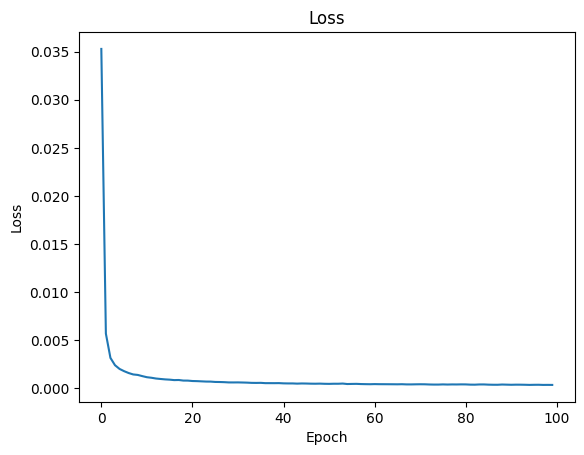

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


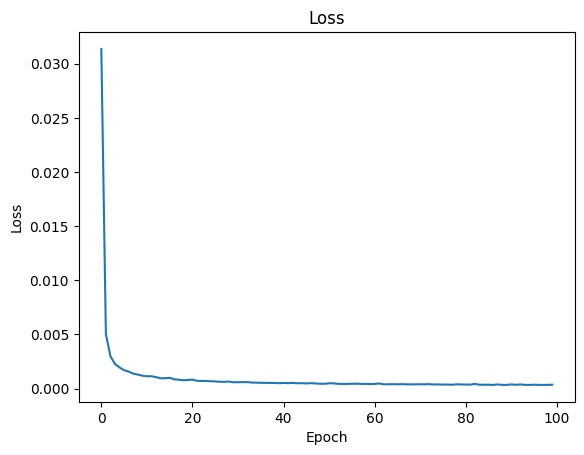

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


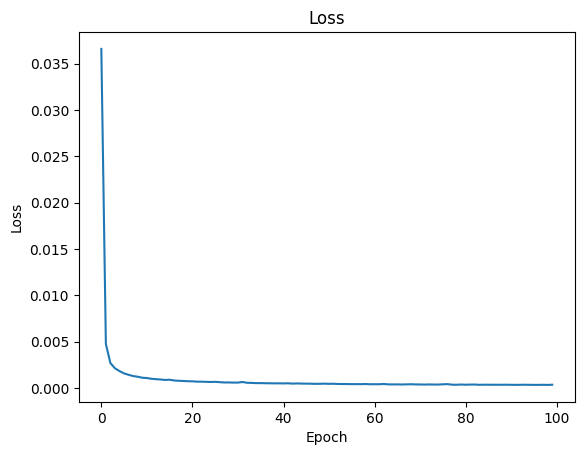

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


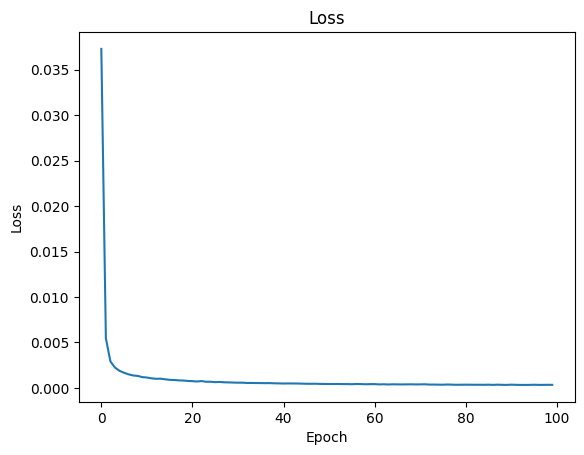

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


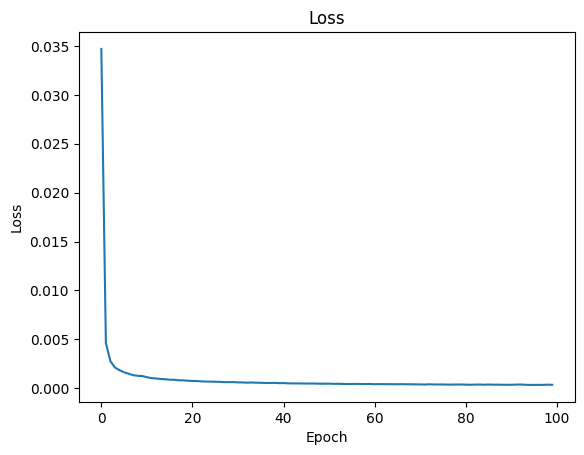

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step


In [10]:
predictions = [ml_investment_signal(pivot_df,train_pivot_df,x) for x in windows]

In [11]:
sinais_ml = [ts_momentum_signal(predictions[0],x) for x in window_ml]

In [12]:
sinais_momentum = [ts_momentum_signal(pivot_df,x) for x in windows]
sinais_rsi = [relative_strength_index(pivot_df,x) for x in windows]
sinais_bb = [bollinger_bands(pivot_df,x) for x in windows]
sinais_mrc = [mean_reversion_channel(pivot_df,x) for x in windows]

In [13]:
def create_regression_training_testing(df, sinais_momentum, sinais_rsi, sinais_bb, sinais_mrc):
    if 'Date' in df.columns:
        df.set_index('Date', inplace=True)

    # List of windows/intervals
    windows = [10,30,60,120, 300]

    # ---  Targets (Percentage Returns) ---

    def calculate_targets(df, intervals):
        targets = []
        for interval in intervals:
            # Calculate percentage change over the interval
            percentage_change = (df.shift(-interval) - df) / df
            # Unpivot the DataFrame
            unpivoted_target = percentage_change.reset_index().melt(id_vars='Date', var_name='Active', value_name=f'Target_{interval}')
            targets.append(unpivoted_target)
        return targets

    # Calculate and unpivot targets
    targets = calculate_targets(df, windows)

    # --- Unpivot the Signals ---

    def unpivot_signal_list(signal_list, signal_name, windows):
        unpivoted_signals = []
        for i, df_signal in enumerate(signal_list):
            window = windows[i]
            # Unpivot the DataFrame
            unpivoted_signal = df_signal.reset_index().melt(id_vars='Date', var_name='Active', value_name=f'{signal_name}_{window}')
            unpivoted_signals.append(unpivoted_signal)
        return unpivoted_signals

    # Unpivot the signals
    unpivoted_momentum = unpivot_signal_list(sinais_momentum, 'Momentum', windows)
    unpivoted_rsi = unpivot_signal_list(sinais_rsi, 'RSI', windows)
    unpivoted_bb = unpivot_signal_list(sinais_bb, 'BB', windows)
    unpivoted_mrc = unpivot_signal_list(sinais_mrc, 'MRC', windows)
    all_data = targets + unpivoted_momentum + unpivoted_rsi + unpivoted_bb + unpivoted_mrc

    # Merge all DataFrames on 'Date' and 'Active'
    final_df = reduce(lambda left, right: pd.merge(left, right, on=['Date', 'Active'], how='outer'), all_data)

    # Reset index if needed
    final_df.reset_index(drop=True, inplace=True)
    return final_df

In [14]:
# regression_train_df = create_regression_training_testing(train_pivot_df, sinais_momentum_train, sinais_rsi_train, sinais_bb_train, sinais_mrc_train)
# regression_train_df

In [15]:
regression_test_df = create_regression_training_testing(pivot_df, sinais_momentum, sinais_rsi, sinais_bb, sinais_mrc)
# regression_test_df

In [17]:
def generate_model_predictions(test_df, original_df, models=[10,30,60,120, 300], model_type='catboost'):
    """
    This function takes a DataFrame and returns a list of pivoted DataFrames,
    each containing predicted targets for each model (target window).

    Parameters:
    - df: DataFrame containing the data for prediction.
    - models: List of target windows (e.g., [10,30,60,120,300]).
    - model_type: The type of model to use ('catboost' or 'xgboost')

    Returns:
    - List of pivoted DataFrames, one for each target window.
    """
    import numpy as np
    import pandas as pd
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.compose import ColumnTransformer

    # Save the first 300 dates to use as NaN placeholders
    if original_df is not None:
        original_dates = original_df.index[:300]
    else:
        raise ValueError("Please provide pivot_df to retrieve the first 300 dates.")
    
    # Drop rows where 'Momentum_300' is NaN
    test_df = test_df.dropna(subset=['Momentum_300']).reset_index(drop=True)
    test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Exclude 'Date' and target columns from features
    feature_columns = [col for col in test_df.columns if not col.startswith('Target_') and col != 'Date']

    # Features for prediction
    X = test_df[feature_columns]

    # Identifiers to keep track of 'Date' and 'Active'
    identifiers = test_df[['Date', 'Active']]
    identifiers = identifiers.loc[X.index].reset_index(drop=True)
    X.reset_index(drop=True, inplace=True)

    # Fill remaining NaNs with zero
    X.fillna(0, inplace=True)

    # Identify numerical and categorical columns
    numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = ['Active']

    # Ensure 'Active' is treated as categorical
    X['Active'] = X['Active'].astype(str)

    pivoted_predictions_list = []

    for target_window in models:
        if model_type.lower() == 'catboost':
            from catboost import CatBoostRegressor, Pool

            model = CatBoostRegressor()
            model.load_model(f'ML Models/Categorical-Models/catboost_model_{target_window}.cbm')

            cat_features_indices = [X.columns.get_loc(col) for col in categorical_cols]

            data_pool = Pool(X, cat_features=cat_features_indices)

            y_pred = model.predict(data_pool)

        elif model_type.lower() == 'xgboost':
            from xgboost import XGBRegressor

            model = XGBRegressor()
            model.load_model(f'ML Models/Non-Categorical Models/xgboost_model_{target_window}.json')

            X_numeric = X.drop(columns=['Active'])

            numerical_cols = X_numeric.columns.tolist()

            # Apply the same preprocessing pipeline as in training
            numeric_transformer = Pipeline(steps=[
                ('scaler', StandardScaler())
            ])

            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numerical_cols)
                ]
            )

            # Preprocess the data
            X_processed = preprocessor.fit_transform(X_numeric)

            # Convert the processed data back to DataFrame
            X_model = pd.DataFrame(X_processed, columns=numerical_cols)

            # Ensure the feature order matches the model's expected input
            X_model = X_model[model.feature_names_in_]

            y_pred = model.predict(X_model)

        else:
            raise ValueError(f"Model '{model_type}' is not supported. Choose 'catboost' or 'xgboost'.")

        # Create a DataFrame with identifiers and predictions
        predictions_df = identifiers.copy()
        predictions_df['Predicted_Target'] = y_pred

        # Pivot the DataFrame
        pivoted_predictions = predictions_df.pivot(index='Date', columns='Active', values='Predicted_Target')

        # Prepend 300 NaN rows with the first 300 dates from pivot_df
        nan_rows = pd.DataFrame(index=original_dates, columns=pivoted_predictions.columns)
        pivoted_predictions = pd.concat([nan_rows, pivoted_predictions])

        # Append to the list
        pivoted_predictions_list.append(pivoted_predictions)

    return pivoted_predictions_list



sinais_catboost = generate_model_predictions(
    regression_test_df,
    pivot_df,
    models=[10,30,60,120, 300],
    model_type='catboost'
)

sinais_xgboost = generate_model_predictions(
    regression_test_df,
    pivot_df,
    models=[10,30,60,120, 300],
    model_type='xgboost'
)

# Access predictions for a specific target window
catboost_predictions_30 = sinais_catboost[1]
xgboost_predictions_30 = sinais_xgboost[1]

## Alocação do portfolio

In [18]:
def calcula_quantis(df_sinal, quantis=[0.7, 0.3]):
    df_sinal['upper_signal_boundry'] = df_sinal.apply(lambda row: row.quantile(quantis[0]), axis=1)
    df_sinal['lower_signal_boundry'] = df_sinal.apply(lambda row: row.quantile(quantis[1]), axis=1)

    df_above_upper = df_sinal.gt(df_sinal['upper_signal_boundry'], axis=0).drop(columns=['upper_signal_boundry', 'lower_signal_boundry'])
    df_below_lower = df_sinal.lt(df_sinal['lower_signal_boundry'], axis=0).drop(columns=['upper_signal_boundry', 'lower_signal_boundry'])
    
    return (df_above_upper, df_below_lower)

def calculate_weights_above(row):
        num_trues = row.sum()  # Conta o número de 'True' em cada linha
        if num_trues > 0:
            return row.astype(float) * (1 / num_trues)  # Atribui 1/n_trues para cada True
        else:
            return row.astype(float)

def recebe_sinal_calcula_pesos(df_sinal):
    df_above_upper, df_below_lower = calcula_quantis(df_sinal, quantis=[0.8, 0.2])
    
    weights_above = df_above_upper.apply(calculate_weights_above, axis=1)
    weights_below = df_below_lower.apply(calculate_weights_above, axis=1) * -1

    combined_weights = weights_above.fillna(0) + weights_below.fillna(0)
    
    return combined_weights

In [19]:
pesos_momentum = [recebe_sinal_calcula_pesos(sinais_momentum[i]) for i in range(0,len(sinais_momentum))]
pesos_rsi = [recebe_sinal_calcula_pesos(sinais_rsi[i]) for i in range(0,len(sinais_rsi))]
pesos_bb = [recebe_sinal_calcula_pesos(sinais_bb[i]) for i in range(0,len(sinais_bb))]
pesos_mrc = [recebe_sinal_calcula_pesos(sinais_mrc[i]) for i in range(0,len(sinais_mrc))]
pesos_ml = [recebe_sinal_calcula_pesos(sinais_ml[i]) for i in range(0,len(sinais_ml))]
pesos_catboost = [recebe_sinal_calcula_pesos(sinais_catboost[i]) for i in range(0,len(sinais_catboost))]

In [20]:
pesos_ml = [recebe_sinal_calcula_pesos(sinais_ml[i]) for i in range(0,len(sinais_ml))]

## Ajuste pela volatilidade alvo

In [21]:
def calculate_weights_above(row):
        num_trues = row.sum()  # Conta o número de 'True' em cada linha
        if num_trues > 0:
            return row.astype(float) * (1 / num_trues)  # Atribui 1/n_trues para cada True
        else:
            return row.astype(float)
        
def adjust_leg_weights(leg_weights, these_returns, vol_target, weight_clip=0.1):
    long_weights_cov = these_returns[leg_weights.index].cov()
    vol = np.sqrt(np.dot(leg_weights.T, np.dot(long_weights_cov, leg_weights))) * np.sqrt(24*60*252)
     # Verificar a razão entre a volatilidade calculada e a volatilidade alvo
    vol_ratio = vol_target / vol
    
    # Ajustar os pesos com o vol_ratio limitado
    leg_weights = leg_weights * vol_ratio

    # Limitar pesos a uma faixa razoável para evitar valores extremos
    leg_weights = np.clip(leg_weights, -weight_clip, weight_clip)
    return leg_weights
        
def adjust_longshort_weights(pivot_df, combined_weights, vol_target, window):
    returns = pivot_df.ffill().pct_change()
    returns.index = pd.to_datetime(returns.index)

    adjusted_weights = []
    for num_index in range(len(combined_weights.index)):

        these_weights = combined_weights.loc[combined_weights.index[num_index]]
        these_returns = returns.loc[combined_weights.index[max(0, num_index - window)]:combined_weights.index[num_index]]

        long_weights = adjust_leg_weights(these_weights[these_weights > 0], these_returns, vol_target)
        short_weights = adjust_leg_weights(these_weights[these_weights < 0], these_returns, vol_target)

        weights = pd.concat([long_weights, short_weights], axis=0)
        
        adjusted_weights.append(adjust_leg_weights(weights,these_returns,vol_target, window ))
        
    adjusted_weights = pd.concat(adjusted_weights, axis=1).T
    return adjusted_weights

In [22]:
adjusted_individual_weights_momentum = [adjust_longshort_weights(pivot_df, pesos_momentum[i], vol_target, windows[i]) for i in range(0,len(pesos_momentum))]
adjusted_individual_weights_rsi = [adjust_longshort_weights(pivot_df, pesos_rsi[i], vol_target, windows[i]) for i in range(0,len(pesos_rsi))]
adjusted_individual_weights_bb = [adjust_longshort_weights(pivot_df, pesos_bb[i], vol_target, windows[i]) for i in range(0,len(pesos_bb))]
adjusted_individual_weights_mrc = [adjust_longshort_weights(pivot_df, pesos_mrc[i], vol_target, windows[i]) for i in range(0,len(pesos_mrc))]
adjusted_individual_weights_ml = [adjust_longshort_weights(pivot_df, pesos_ml[i], vol_target, windows[i]) for i in range(0,len(pesos_ml))]
adjusted_individual_weights_catboost = [adjust_longshort_weights(pivot_df, pesos_catboost[i], vol_target, windows[i]) for i in range(0,len(pesos_catboost))]

In [23]:
adjusted_individual_weights_ml = [adjust_longshort_weights(pivot_df, pesos_ml[i], vol_target, windows[i]) for i in range(0,len(pesos_ml))]

## Cotização do portfolio

In [24]:
def portfolio_quota(weights, pivot_df):
    returns = pivot_df.ffill().pct_change()

    portfolio_weights = weights.dropna(how='all').shift(1)

    individual_asset_returns = portfolio_weights.ffill() * returns.loc[portfolio_weights.index, portfolio_weights.columns].ffill()

    portfolio_returns = individual_asset_returns.sum(axis=1)

    cota = (portfolio_returns + 1).cumprod()

    return cota

In [25]:
individual_momentum_return = [portfolio_quota(adjusted_individual_weights_momentum[i],pivot_df) for i in range(0,len(adjusted_individual_weights_momentum))]
individual_rsi_return = [portfolio_quota(adjusted_individual_weights_rsi[i],pivot_df) for i in range(0,len(adjusted_individual_weights_rsi))]
individual_bb_return = [portfolio_quota(adjusted_individual_weights_bb[i],pivot_df) for i in range(0,len(adjusted_individual_weights_bb))]
individual_mrc_return = [portfolio_quota(adjusted_individual_weights_mrc[i],pivot_df) for i in range(0,len(adjusted_individual_weights_mrc))]
individual_ml_return = [portfolio_quota(adjusted_individual_weights_ml[i],pivot_df) for i in range(0,len(adjusted_individual_weights_ml))]
individual_catboost_return = [portfolio_quota(adjusted_individual_weights_catboost[i],pivot_df) for i in range(0,len(adjusted_individual_weights_catboost))]

In [26]:
individual_ml_return = [portfolio_quota(adjusted_individual_weights_ml[i],pivot_df) for i in range(0,len(adjusted_individual_weights_ml))]

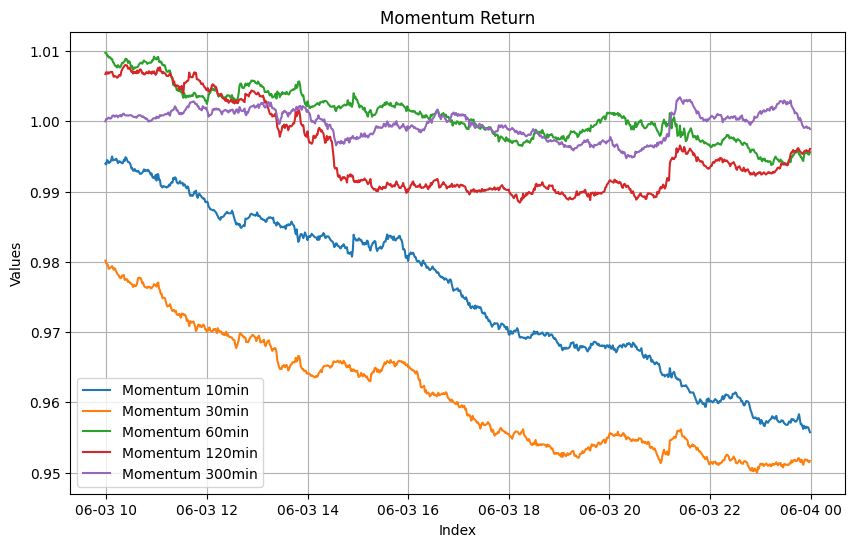

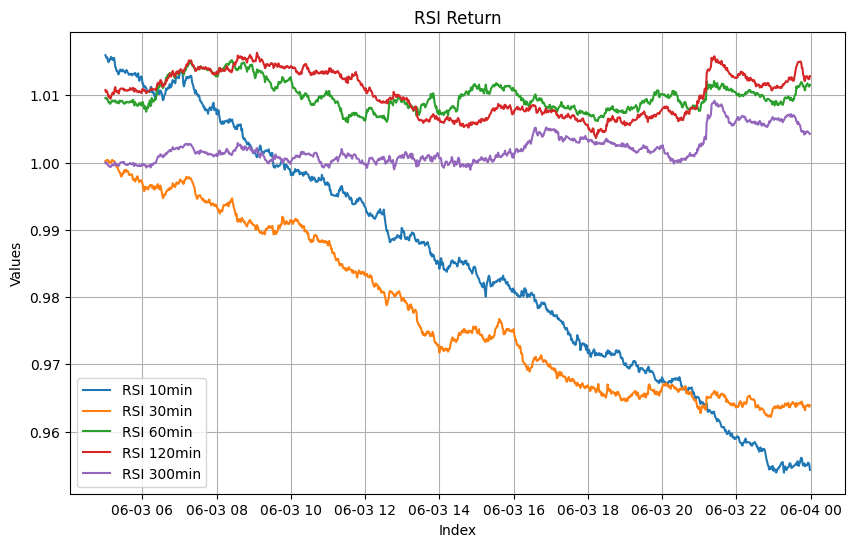

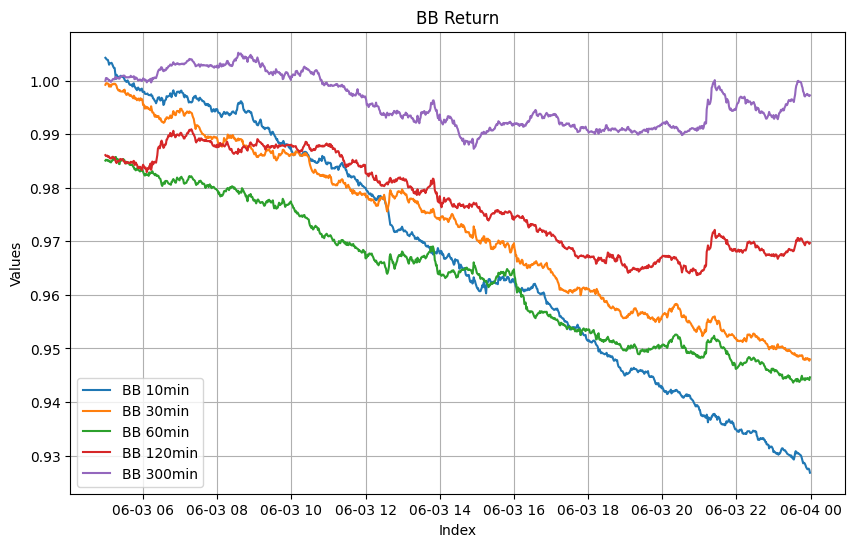

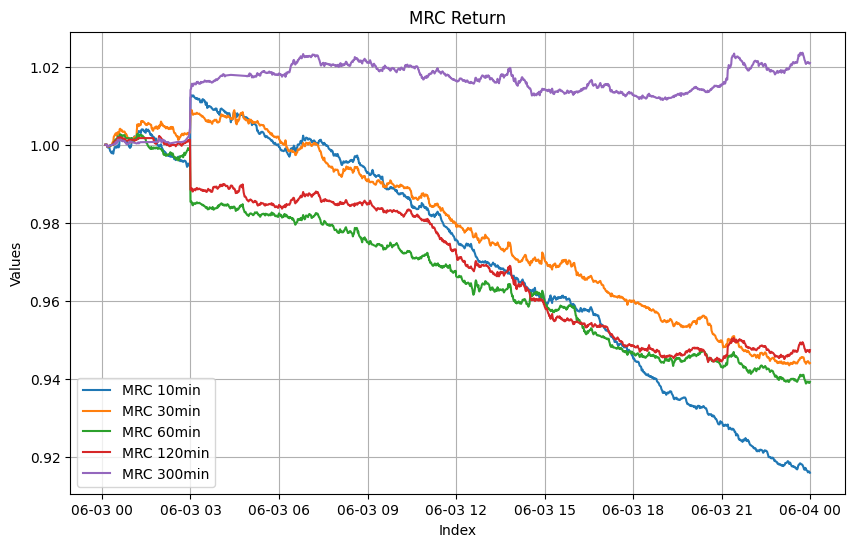

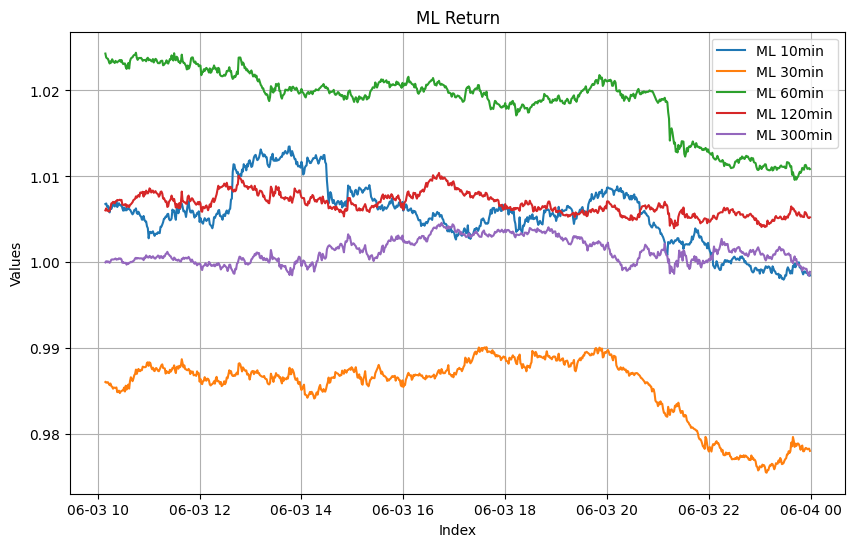

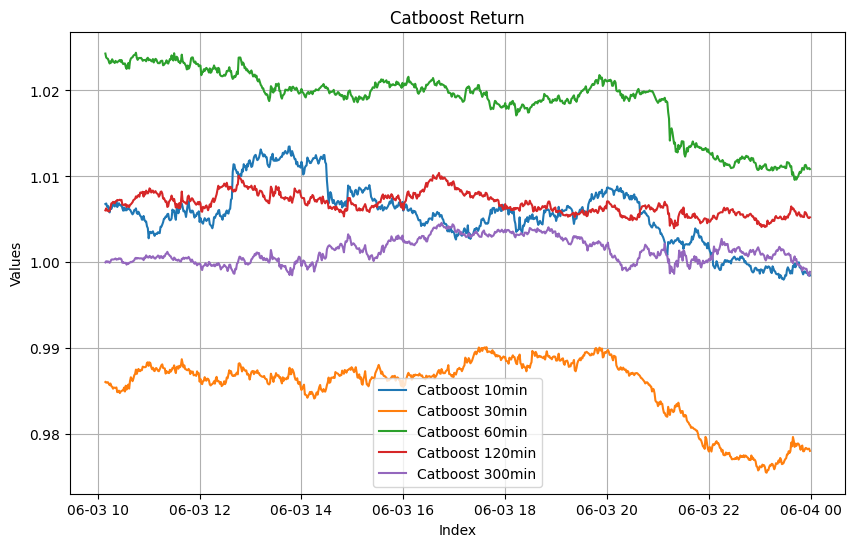

In [27]:
def plot_series_with_windows(series_list, windows, title, label_prefix):
    # Encontra o maior índice inicial entre as séries
    max_start_index = max(series.index[0] for series in series_list)
    
    plt.figure(figsize=(10, 6))  # Tamanho da figura
    
    for i, series in enumerate(series_list):
        # Ajusta cada série para começar no maior índice inicial
        aligned_series = series[series.index >= max_start_index]
        
        plt.plot(aligned_series.index, aligned_series, label=f"{label_prefix} {windows[i]}min")
    
    plt.title(title)
    plt.xlabel('Index') 
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_series_with_windows(individual_momentum_return, windows, "Momentum Return", "Momentum")
plot_series_with_windows(individual_rsi_return, windows, "RSI Return", "RSI")
plot_series_with_windows(individual_bb_return, windows, "BB Return", "BB")
plot_series_with_windows(individual_mrc_return, windows, "MRC Return", "MRC")
plot_series_with_windows(individual_ml_return, windows, "ML Return", "ML")
plot_series_with_windows(individual_ml_return, windows, "Catboost Return", "Catboost")

# Backtesting Utilizando diversas volatilidades

In [28]:
def portfolio(pivot_df, vol_target, windows, sinais):
    pesos = [recebe_sinal_calcula_pesos(sinais[i]) for i in range(0,len(sinais))]
    adjusted_individual_weights = [adjust_longshort_weights(pivot_df, pesos[i], vol_target, windows[i]) for i in range(0,len(pesos))]
    individual_return = [portfolio_quota(adjusted_individual_weights[i],pivot_df) for i in range(0,len(adjusted_individual_weights))]
    return individual_return

momentum_return_diff_vols = [portfolio(pivot_df, vols_target[i], windows, sinais_momentum) for i in range(0,len(vols_target))]
rsi_return_diff_vols = [portfolio(pivot_df, vols_target[i], windows, sinais_rsi) for i in range(0,len(vols_target))]
bb_return_diff_vols = [portfolio(pivot_df, vols_target[i], windows, sinais_bb) for i in range(0,len(vols_target))]
mrc_return_diff_vols = [portfolio(pivot_df, vols_target[i], windows, sinais_mrc) for i in range(0,len(vols_target))]
ml_return_diff_vols = [portfolio(pivot_df, vols_target[i], windows, sinais_ml) for i in range(0,len(vols_target))]
catboost_return_diff_vols = [portfolio(pivot_df, vols_target[i], windows, sinais_catboost) for i in range(0,len(vols_target))]

In [29]:
ml_return_diff_vols = [portfolio(pivot_df, vols_target[i], windows, sinais_ml) for i in range(0,len(vols_target))]

In [41]:
import matplotlib.pyplot as plt
import os

def plot_combined_signals(data_dict, windows, title, save_path, vol_label):
    for i, vol in enumerate(vol_label):  # Iterando sobre cada janela
        for j, window in enumerate(windows):
            max_start_index = max(series[i][j].index[0] for name,series in data_dict.items())
            plt.figure(figsize=(10, 6))  # Tamanho da figura
            for signal_name, data in data_dict.items(): # Iterando sobre cada sinal no dicionário de dados
                series = data[i][j] 
                aligned_series = series[series.index >= max_start_index] # Selecionando a série correspondente à janela atual
                plt.plot(aligned_series.index, aligned_series, label=f"{signal_name} {window}min")        
            plt.title(f"{title} - Vol: {vol} - Window: {window}min")
            plt.xlabel('Index')
            plt.ylabel('Portfolio Return')
            plt.legend()
            plt.grid(True)
            # Salvando o gráfico em uma imagem
            file_name = os.path.join(save_path, f"{title.replace(' ', '_')}_vol_{vol}_window_{window}min.png")
            plt.savefig(file_name)  # Salva a figura em um arquivo
            plt.close()  # Fecha a figura para evitar poluição da saída do notebook

# Criando um diretório para salvar os gráficos, se não existir
save_directory = "portfolio_plots"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Organizando os dados em um dicionário para cada sinal
data_signals = {
    "Momentum": momentum_return_diff_vols,
    "RSI": rsi_return_diff_vols,
    "BB": bb_return_diff_vols,
    "MRC": mrc_return_diff_vols,
    "ML": ml_return_diff_vols,
    "Catboost": catboost_return_diff_vols
}

# Gerando um gráfico para cada combinação de volatilidade e janela, consolidando todos os sinais
plot_combined_signals(data_signals, windows, "Portfolio", save_directory,vols_target)


## Agregação de janelas para cada sinal

In [31]:
def calculate_weights_norm(row):
    soma = row.sum() 
    if soma > 0:
        return row.astype(float) * (1 / soma) 
    else:
        return row.astype(float)

def integration_stack(portfolios, pivot_df):
    combined_portfolios = pivot_df * 0
    for portfolio in portfolios:
        portfolio_aligned = portfolio.reindex(pivot_df.index).fillna(0)
        combined_portfolios += portfolio_aligned
    
    combined_portfolios_norm_above = combined_portfolios[combined_portfolios > 0]
    combined_portfolios_norm_below = combined_portfolios[combined_portfolios < 0]
    
    combined_portfolios_norm_above = combined_portfolios_norm_above.apply(calculate_weights_norm,axis = 1)
    combined_portfolios_norm_below = combined_portfolios_norm_below.apply(calculate_weights_norm,axis = 1) * -1

    combined_weights = combined_portfolios_norm_below.fillna(0) + combined_portfolios_norm_above.fillna(0) 

    return combined_weights

        
def adjust_longshort_weights_comp(pivot_df, combined_weights, vol_target):
    returns = pivot_df.ffill().pct_change()
    returns.index = pd.to_datetime(returns.index)

    adjusted_weights = []
    for num_index in range(len(combined_weights.index)):

        these_weights = combined_weights.loc[combined_weights.index[num_index]]
        these_returns = returns.loc[combined_weights.index[max(0, num_index - 60)]:combined_weights.index[num_index]]

        long_weights = adjust_leg_weights(these_weights[these_weights > 0], these_returns, vol_target)
        short_weights = adjust_leg_weights(these_weights[these_weights < 0], these_returns, vol_target)

        weights = pd.concat([long_weights, short_weights], axis=0)
        
        adjusted_weights.append(adjust_leg_weights(weights,these_returns,vol_target))
        
    adjusted_weights = pd.concat(adjusted_weights, axis=1).T
    return adjusted_weights

def composed_signal_weights(pivot_df, vol_target, signals):
    portfolios_weights = [recebe_sinal_calcula_pesos(signals[i]) for i in range(0,len(signals))]
    combined_weights = integration_stack(portfolios_weights, pivot_df)
    adjusted_weights = adjust_longshort_weights_comp(pivot_df, combined_weights,vol_target)
    return adjusted_weights

In [32]:
momentum_compose_weights = [composed_signal_weights(pivot_df, vols_target[i], sinais_momentum) for i in range(0,len(vols_target))]
rsi_compose_weights = [composed_signal_weights(pivot_df, vols_target[i], sinais_rsi) for i in range(0,len(vols_target))]
bb_compose_weights = [composed_signal_weights(pivot_df, vols_target[i], sinais_bb) for i in range(0,len(vols_target))]
mrc_compose_weights = [composed_signal_weights(pivot_df, vols_target[i], sinais_mrc) for i in range(0,len(vols_target))]
ml_compose_weights = [composed_signal_weights(pivot_df, vols_target[i], sinais_ml) for i in range(0,len(vols_target))]
catboost_compose_weights = [composed_signal_weights(pivot_df, vols_target[i], sinais_catboost) for i in range(0,len(vols_target))]

In [33]:
momentum_compose_returns = [portfolio_quota(momentum_compose_weights[i], pivot_df) for i in range(0,len(vols_target))]
rsi_compose_returns = [portfolio_quota(rsi_compose_weights[i],pivot_df) for i in range(0,len(vols_target))]
bb_compose_returns = [portfolio_quota(bb_compose_weights[i],pivot_df) for i in range(0,len(vols_target))]
mrc_compose_returns = [portfolio_quota(mrc_compose_weights[i],pivot_df) for i in range(0,len(vols_target))]
ml_compose_returns = [portfolio_quota(ml_compose_weights[i],pivot_df) for i in range(0,len(vols_target))]
catboost_compose_returns = [portfolio_quota(catboost_compose_weights[i],pivot_df) for i in range(0,len(vols_target))]

### Benchmark para cada volatilidade

In [34]:
def weights_benchmark(row):
        n = len(row)
        return (row/row)/n

def benchmark(pivot_df, vol_target):
    weights = pivot_df.apply(weights_benchmark, axis=1)
    adjusted_weights = adjust_longshort_weights_comp(pivot_df, weights, vol_target)
    benchmark_return = portfolio_quota(adjusted_weights,pivot_df)
    return benchmark_return

benchmark = [benchmark(pivot_df,vols_target[i]) for i in range(0,len(vols_target))]

## Backtesting dos sinais compostos comparados com benchmark

In [40]:
import os
import matplotlib.pyplot as plt

def plot_combined_signals(data_dict, title, save_path, vol_label):
    # Verificação: garantir que cada sinal em data_dict tenha o mesmo número de séries que vol_label
    for signal_name, data in data_dict.items():
        if len(data) != len(vol_label):
            raise ValueError(f"O sinal '{signal_name}' possui {len(data)} séries, mas vol_label possui {len(vol_label)} volatilidades.")
    
    for i, vol in enumerate(vol_label):  # Iterando sobre cada volatilidade
        plt.figure(figsize=(10, 6))  # Tamanho da figura
        max_start_index = max(series[i].index[0] for name,series in data_dict.items())
        for signal_name, data in data_dict.items():  # Iterando sobre cada sinal no dicionário de dados
            series = data[i]
            aligned_series = series[series.index >= max_start_index]
            plt.plot(aligned_series.index, aligned_series, label=f"{signal_name}")        
        
        plt.title(f"{title} - Vol: {vol}")
        plt.xlabel('Index')
        plt.ylabel('Portfolio Return')
        plt.legend()
        plt.grid(True)
        
        # Salvando o gráfico em uma imagem
        file_name = os.path.join(save_path, f"{title.replace(' ', '_')}_vol_{vol}.png")
        plt.savefig(file_name)  # Salva a figura em um arquivo
        plt.close()  # Fecha a figura para evitar poluição da saída do notebook

# Criando um diretório para salvar os gráficos, se não existir
save_directory = "portfolio_plots"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Organizando os dados em um dicionário para cada sinal
data_signals = {
    "Momentum_Composed": momentum_compose_returns,
    "RSI_Composed": rsi_compose_returns,
    "BB_Composed": bb_compose_returns,
    "MRC_Composed": mrc_compose_returns,
    "ML_Composed": ml_compose_returns,
    "Catboost_Composed": catboost_compose_returns,
    "benchmark": benchmark
}

# Gerando um gráfico para cada combinação de volatilidade e janela, consolidando todos os sinais
plot_combined_signals(data_signals, "Portfolio", save_directory, vols_target)


## Integrando sinais compostos para geração do Fator de Momentum

In [42]:
def combine_weights_momentum(pivot_df,portfolios_weights,vol_target):
    combined_weights = integration_stack(portfolios_weights, pivot_df)
    adjusted_weights = adjust_longshort_weights_comp(pivot_df, combined_weights,vol_target)
    return adjusted_weights

In [43]:
momentum_composed_weights = composed_signal_weights(pivot_df, vol_target, sinais_momentum)
rsi_composed_weights = composed_signal_weights(pivot_df, vol_target, sinais_rsi) 
bb_composed_weights = composed_signal_weights(pivot_df, vol_target, sinais_bb) 
mrc_composed_weights = composed_signal_weights(pivot_df, vol_target, sinais_mrc) 
ml_composed_weights = composed_signal_weights(pivot_df, vol_target, sinais_ml)
catboost_composed_weights = composed_signal_weights(pivot_df, vol_target, sinais_catboost)

composed_portfolios_weights = [momentum_composed_weights,rsi_composed_weights,bb_composed_weights,mrc_composed_weights,ml_composed_weights,catboost_composed_weights]

momentum_factor_weights = [combine_weights_momentum(pivot_df, composed_portfolios_weights, vols_target[i]) for i in range(0,len(vols_target))]
momentum_factor = [portfolio_quota(momentum_factor_weights[i], pivot_df) for i in range(0,len(momentum_factor_weights))]

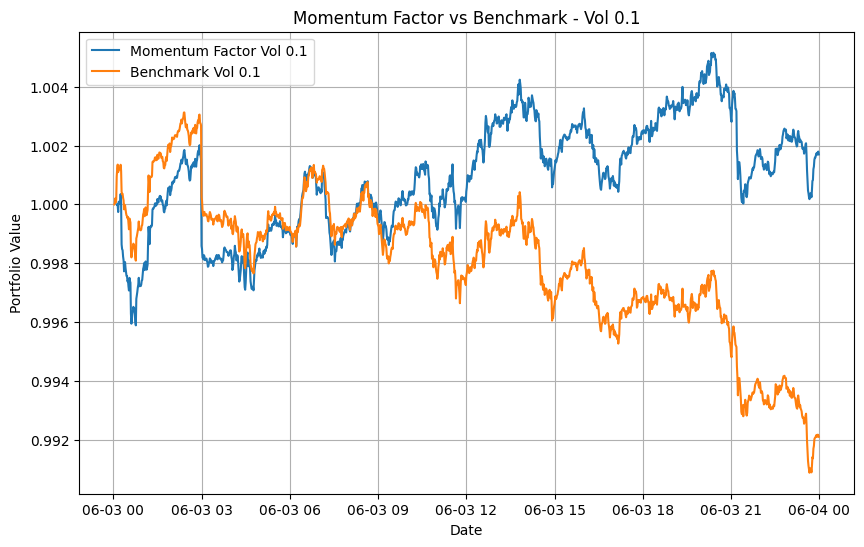

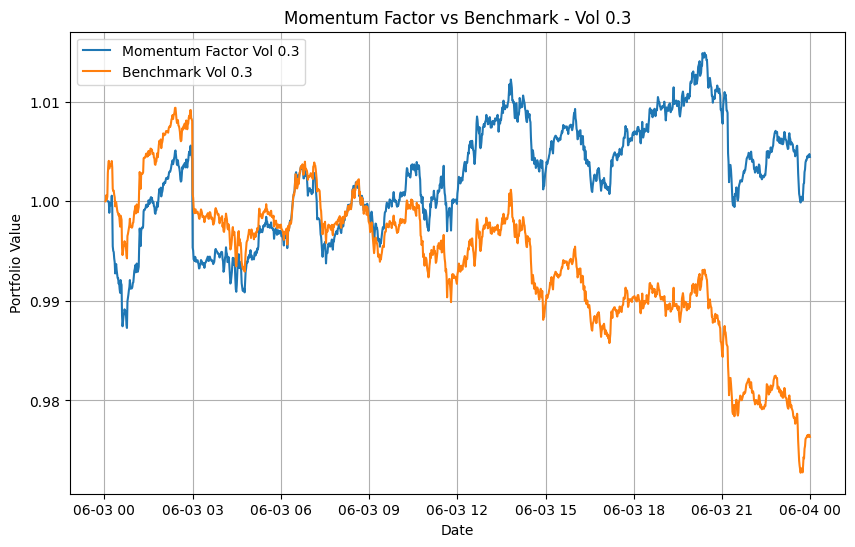

In [44]:
import matplotlib.pyplot as plt

def plot_momentum_vs_benchmark(momentum_factor, benchmark, vols_target):
    for i, vol in enumerate(vols_target):
        plt.figure(figsize=(10, 6))
        
        plt.plot(momentum_factor[i].index, momentum_factor[i], label=f"Momentum Factor Vol {vol}")
        plt.plot(benchmark[i].index, benchmark[i], label=f"Benchmark Vol {vol}")
        plt.title(f"Momentum Factor vs Benchmark - Vol {vol}")
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value')
        plt.legend()
        plt.grid(True)
        plt.show()

plot_momentum_vs_benchmark(momentum_factor, benchmark, vols_target)

## Análise de qualidade dos sinais

In [45]:
def calculate_cagr(series, period):
    initial_value = series.iloc[0]
    final_value = series.iloc[-1]
    return (final_value / initial_value) ** (1 / period) - 1

def calculate_drawdown(series):
    max_series = series.cummax()
    drawdown = (max_series - series) / max_series
    max_drawdown = drawdown.max()
    return drawdown, max_drawdown

def calculate_information_ratio(strategy_series, benchmark_series):
    excess_return = strategy_series - benchmark_series
    avg_excess_return = excess_return.mean()
    tracking_error = excess_return.std()
    if tracking_error == 0:
        return np.nan
    return avg_excess_return / tracking_error

def calculate_return_metrics(series):
    mean_return = series.mean()
    median_return = series.median()
    std_return = series.std()
    skewness_return = series.skew()
    kurtosis_return = series.kurtosis()
    return mean_return, median_return, std_return, skewness_return, kurtosis_return

In [46]:
import pandas as pd

def add_metrics_row(df, series, series_name, window, vol, benchmark):
    # Calculando o número de horas com base na suposição de dados minuto a minuto
    num_hours = len(series) / 60

    # Calcular CAGR para a estratégia
    cagr_strategy = calculate_cagr(series, num_hours)

    # Calcular Drawdown
    _, max_drawdown = calculate_drawdown(series)

    # Calcular métricas de retorno
    mean_return, median_return, std_return, skewness_return, kurtosis_return = calculate_return_metrics(series)

    # Calcular Information Ratio usando a série de benchmark específica
    ir = calculate_information_ratio(series, benchmark)

    # Criando a nova linha
    new_row = pd.DataFrame([[
        f"{series_name}_vol{vol}_{window}", cagr_strategy, max_drawdown, ir,
        mean_return, median_return, std_return, skewness_return, kurtosis_return
    ]], columns=[
        'Series', 'CAGR', 'Max_Drawdown', 'Information_Ratio', 'Mean_Return', 'Median_Return',
        'Std_Return', 'Skewness_Return', 'Kurtosis_Return'
    ])

    # Adicionando a nova linha ao DataFrame existente
    df = pd.concat([df, new_row], ignore_index=True)

    return df

def process_analytics(series_list, series_names, windows, vols_target, benchmarks):
    # Criar um dicionário de DataFrames, um para cada volatilidade
    df_dict = {vol: pd.DataFrame(columns=[
        'Series', 'CAGR', 'Max_Drawdown', 'Information_Ratio', 'Mean_Return', 'Median_Return',
        'Std_Return', 'Skewness_Return', 'Kurtosis_Return'
    ]) for vol in vols_target}

    for series_innerlist, series_name in zip(series_list, series_names):
        for series_group, vol, benchmark in zip(series_innerlist, vols_target, benchmarks):  # Itera sobre cada lista de Series e benchmark
            for i, series in enumerate(series_group):  # Itera sobre as Series dentro da lista
                # Adiciona a linha ao DataFrame correspondente à volatilidade `vol`
                df_dict[vol] = add_metrics_row(df_dict[vol], series, series_name, windows[i], vol, benchmark)

    return df_dict

# Nomes das séries
series_names = ['Momentum', 'RSI', 'BB', 'MRC', 'ML', 'Catboost']

# Suponha que `windows` seja definido anteriormente e contenha os intervalos de tempo
series_list = [momentum_return_diff_vols, rsi_return_diff_vols, bb_return_diff_vols, mrc_return_diff_vols, ml_return_diff_vols, catboost_return_diff_vols]

# Processar as métricas para todas as listas com benchmarks específicos para cada volatilidade
df_analytics_dict = process_analytics(series_list, series_names, windows, vols_target, benchmark)

# Associar cada volatilidade a uma série composta
composed_series_map = {
    "Momentum Composed": momentum_compose_returns,
    "RSI Composed": rsi_compose_returns,
    "BB Composed": bb_compose_returns,
    "MRC Composed": mrc_compose_returns,
    "ML Composed": ml_compose_returns,
    "Catboost Composed": catboost_compose_returns,
    "Momentum Factor": momentum_factor
}

# Adicionar apenas uma série composta correspondente para cada volatilidade
for vol, benchmark_i in zip(vols_target, benchmark):
    for series_name, composed_series in composed_series_map.items():
        # Seleciona a série composta específica da volatilidade `vol`
        df_analytics_dict[vol] = add_metrics_row(df_analytics_dict[vol], composed_series[vols_target.index(vol)], 
                                                 series_name, '', vol, benchmark_i)

# Salvar cada DataFrame em um arquivo CSV separado
for vol, df in df_analytics_dict.items():
    df.to_csv(f'../data/signals_analytics_vol_{vol}.csv', index=False)

print("DataFrames para cada volatilidade foram salvos com sucesso.")


DataFrames para cada volatilidade foram salvos com sucesso.


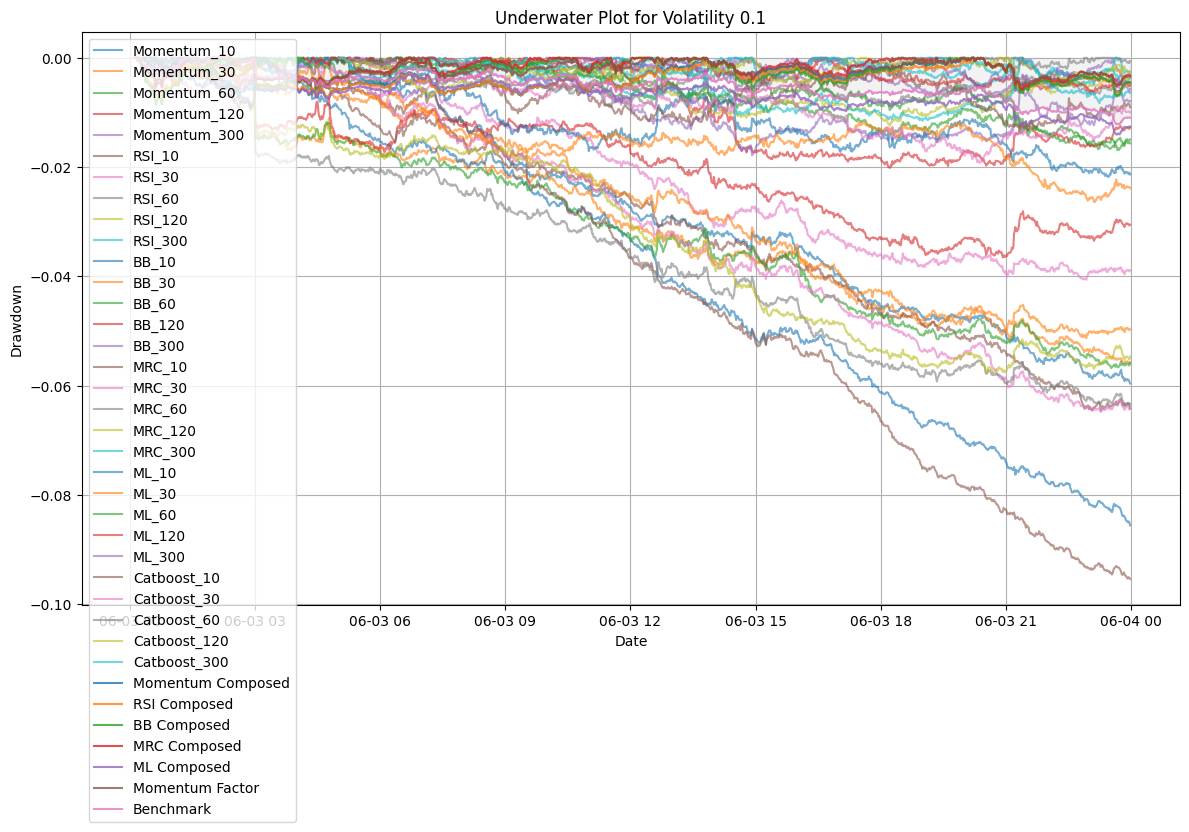

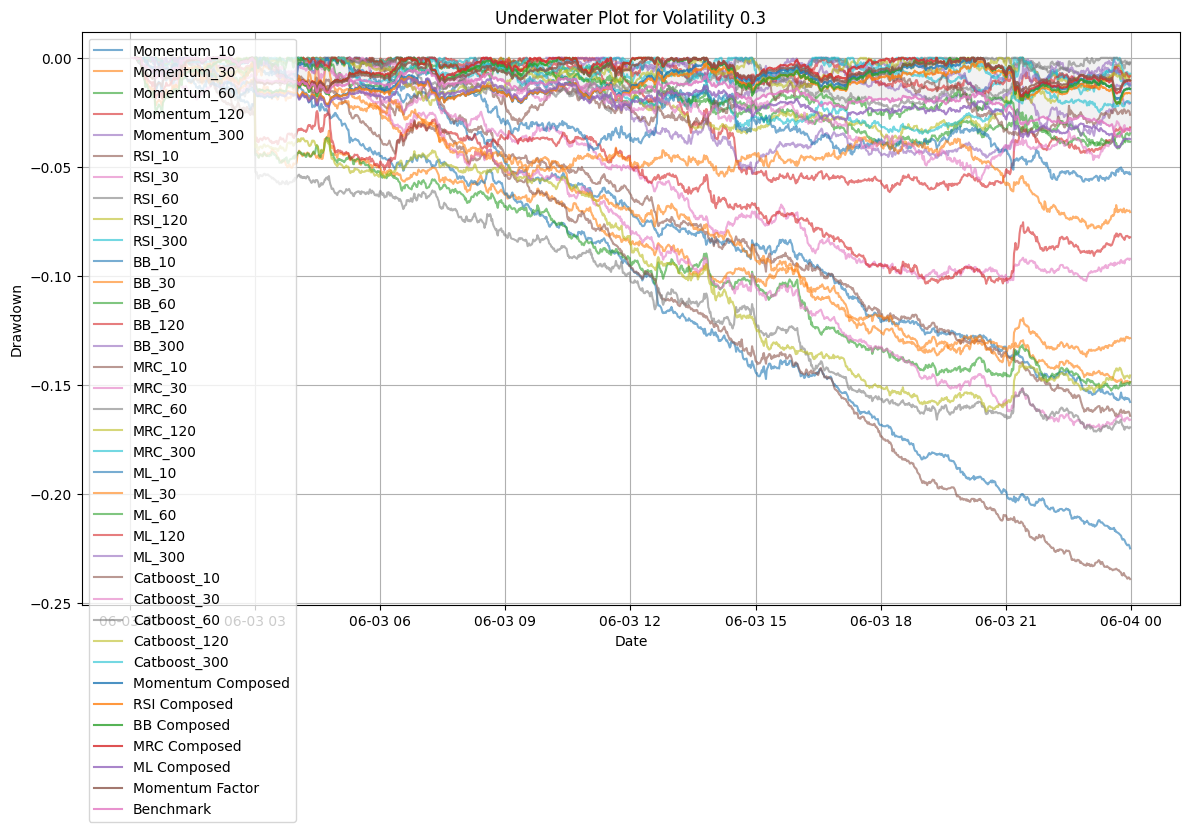

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Função para calcular o drawdown
def calculate_drawdown(series):
    max_series = series.cummax()
    drawdown = (max_series - series) / max_series
    max_drawdown = drawdown.max()
    return drawdown, max_drawdown

# Listas e dicionários de séries de retorno
series_list = [momentum_return_diff_vols, rsi_return_diff_vols, bb_return_diff_vols, mrc_return_diff_vols, ml_return_diff_vols, catboost_return_diff_vols]
series_names = ['Momentum', 'RSI', 'BB', 'MRC', 'ML', 'Catboost']

composed_series_map = {
    "Momentum Composed": momentum_compose_returns,
    "RSI Composed": rsi_compose_returns,
    "BB Composed": bb_compose_returns,
    "MRC Composed": mrc_compose_returns,
    "ML Composed": ml_compose_returns,
    "Momentum Factor": momentum_factor,
    "Benchmark": benchmark
}

# Plotando gráficos underwater consolidados para cada volatilidade
for vol_index, vol in enumerate(vols_target):
    plt.figure(figsize=(12, 8))
    plt.title(f'Underwater Plot for Volatility {vol}')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    
    # Plotando cada série individual para a volatilidade atual
    for series_group, name in zip(series_list, series_names):
        for i,series in enumerate(series_group[vol_index]):  # Seleciona a lista de séries para a volatilidade `vol_index`
            drawdown,max_drawdawn = calculate_drawdown(series)
            plt.plot(drawdown.index, drawdown*-1, label=f'{name}_{windows[i]}', alpha=0.6)
    
    # Plotando séries compostas para a volatilidade atual
    for name, composed_series in composed_series_map.items():
        series = composed_series[vol_index]
        drawdown,max_drawdawn = calculate_drawdown(series)
        plt.plot(drawdown.index, drawdown*-1, label=f'{name}', alpha=0.8)

    # drawdown,max_drawdawn = calculate_drawdown(composed_series_map['Momentum Composed'][vol_index])
    # plt.plot(drawdown.index, drawdown*-1, label=f'{name}', alpha=0.8)

    # drawdown,max_drawdawn = calculate_drawdown(composed_series_map['RSI Composed'][vol_index])
    # plt.plot(drawdown.index, drawdown*-1, label=f'{name}', alpha=0.8)

    # drawdown,max_drawdawn = calculate_drawdown(composed_series_map['BB Composed'][vol_index])
    # plt.plot(drawdown.index, drawdown*-1, label=f'{name}', alpha=0.8)

    # drawdown,max_drawdawn = calculate_drawdown(composed_series_map['MRC Composed'][vol_index])
    # plt.plot(drawdown.index, drawdown*-1, label=f'{name}', alpha=0.8)

    # drawdown,max_drawdawn = calculate_drawdown(composed_series_map['Momentum Factor'][vol_index])
    # plt.plot(drawdown.index, drawdown*-1, label=f'{name}', alpha=0.8)

    # drawdown,max_drawdawn = calculate_drawdown(composed_series_map['Benchmark'][vol_index])
    # plt.plot(drawdown.index, drawdown*-1, label=f'{name}', alpha=0.8)
    
    plt.fill_between(drawdown.index, drawdown*-1, 0, color='gray', alpha=0.1)  # Preenchimento leve para visualização
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

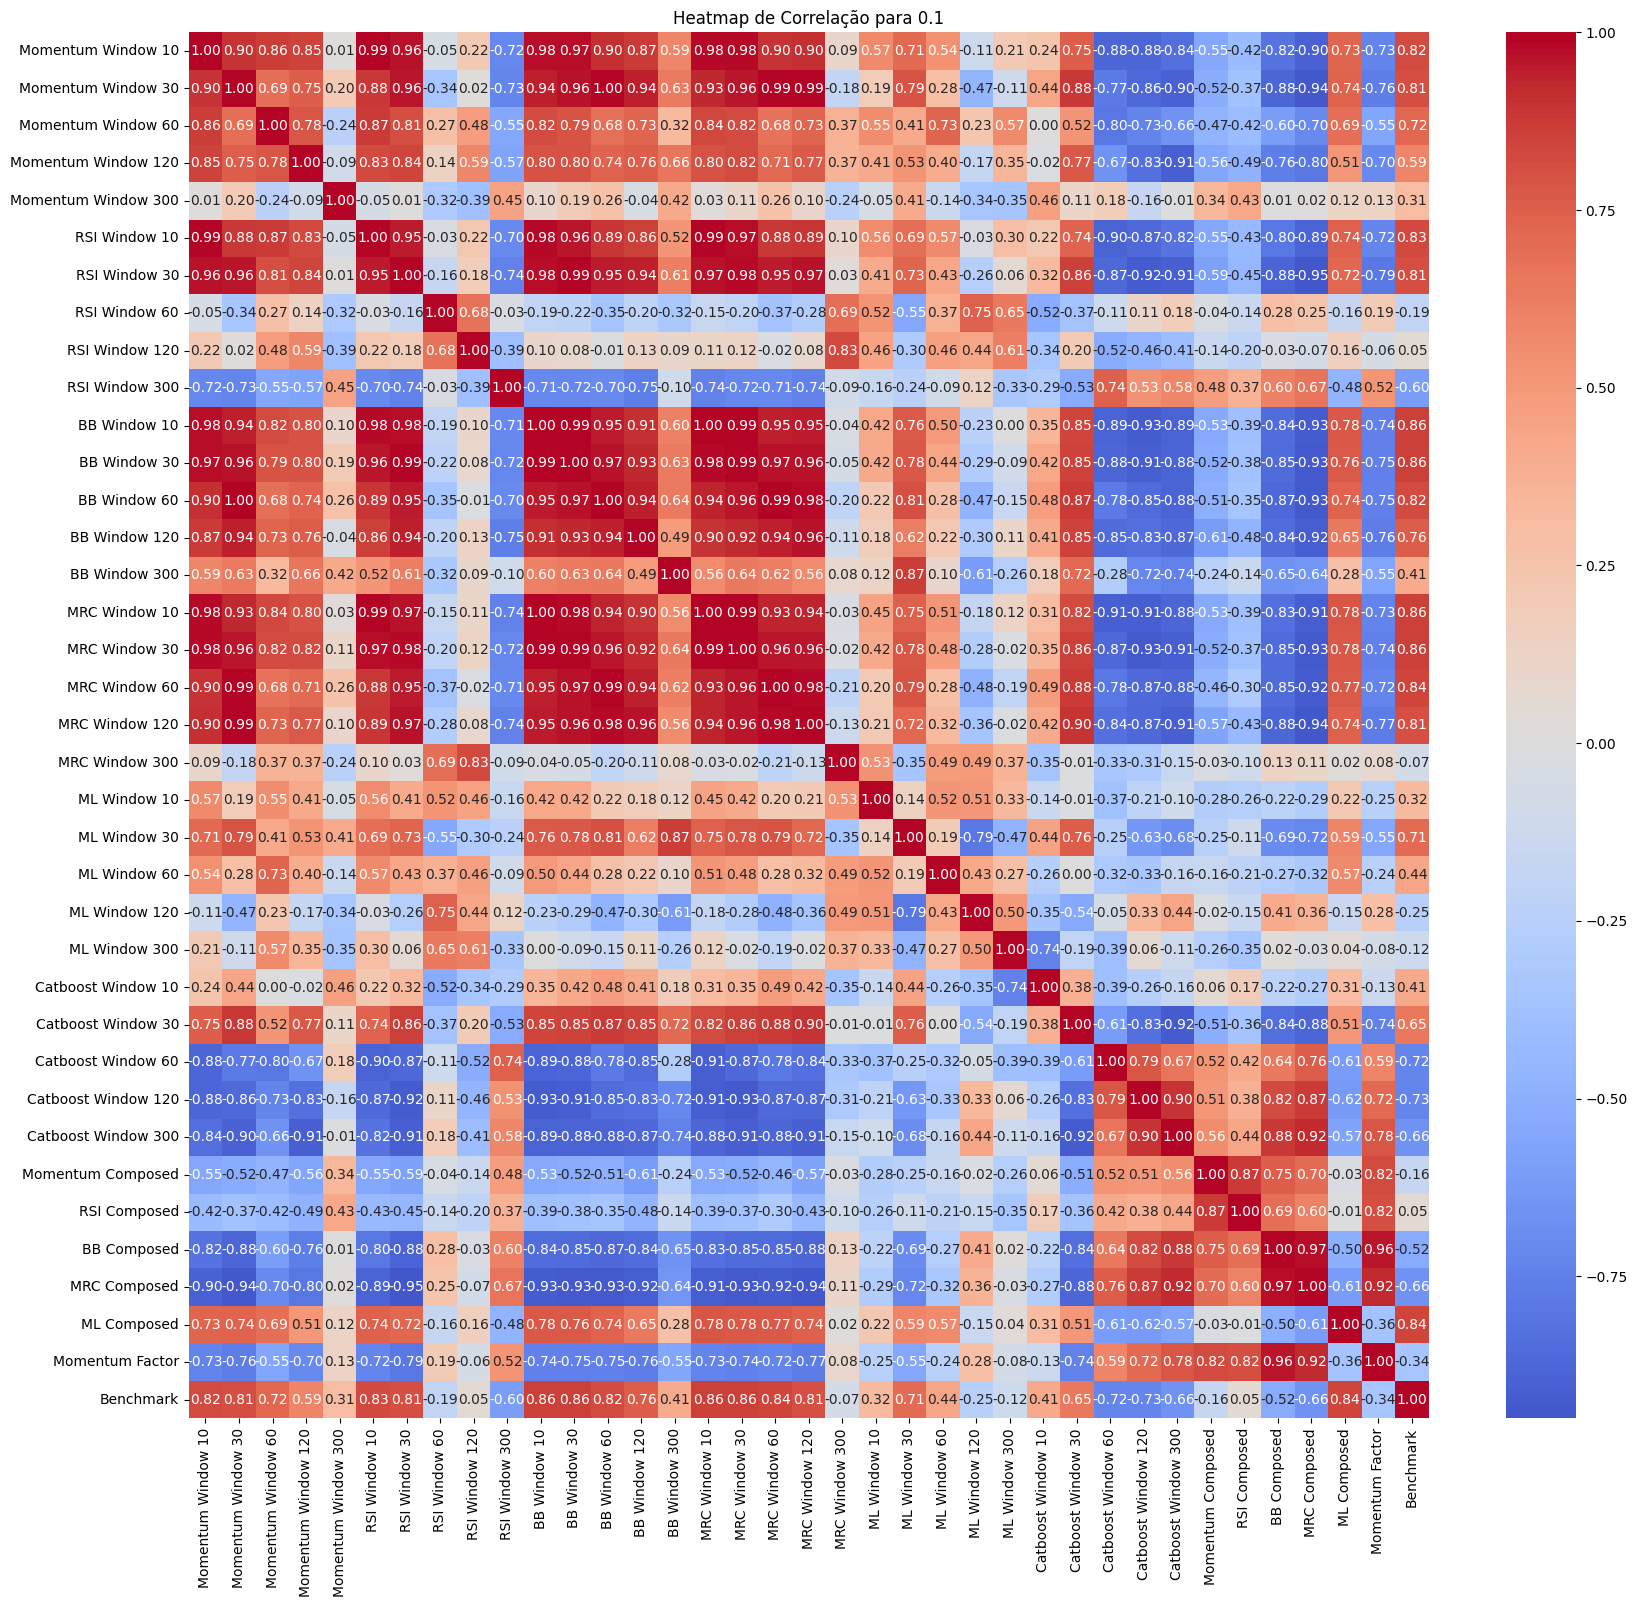

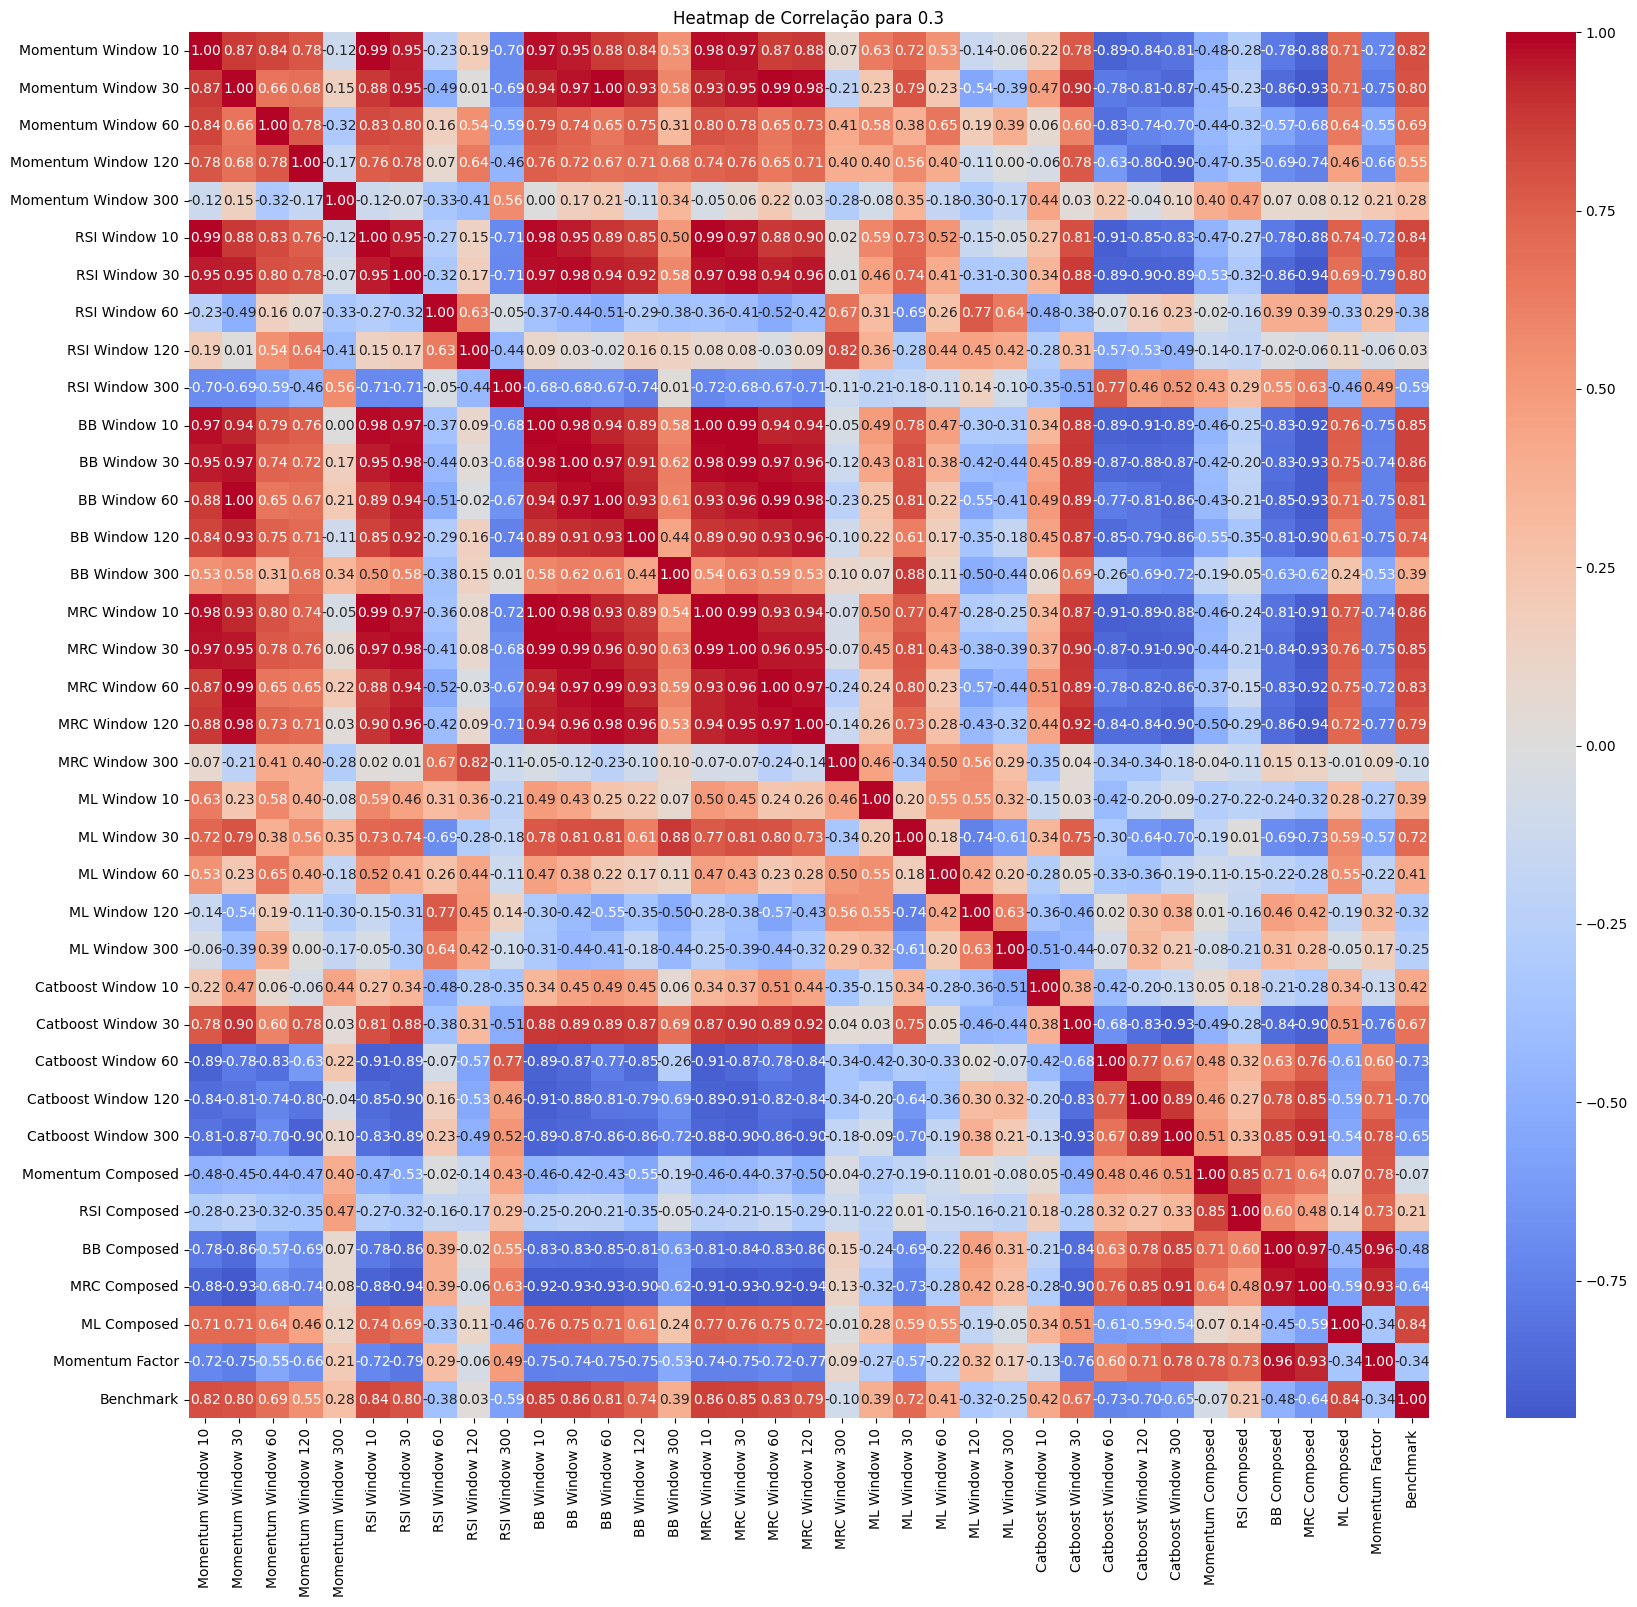

In [48]:
import seaborn as sns

def align_series_length(series_list):
    # Encontra o comprimento máximo entre todas as séries
    max_length = max(len(series) for series in series_list)
    
    # Expande cada série para o comprimento máximo, preenchendo com NaN onde necessário
    aligned_series = [pd.concat([series, pd.Series([np.nan] * (max_length - len(series)))], ignore_index=True) 
                      if len(series) < max_length else series 
                      for series in series_list]
    
    return aligned_series



series_dict = {}

for vol_index, vol_name in enumerate(vols_target):
    all_series = []
    series_labels = []
    
    # Adicionando cada estratégia para a volatilidade atual
    for series_group, group_name in zip(
            [momentum_return_diff_vols, rsi_return_diff_vols, bb_return_diff_vols, mrc_return_diff_vols, ml_return_diff_vols, catboost_return_diff_vols],
            ["Momentum", "RSI", "BB", "MRC", "ML","Catboost"]):
        
        for window_index, series in enumerate(series_group[vol_index]):
            all_series.append(series)
            series_labels.append(f"{group_name} Window {windows[window_index]}")

    # Adicionando séries compostas para a volatilidade atual
    for name, composed_series in composed_series_map.items():
        all_series.append(composed_series[vol_index])
        series_labels.append(name)

    # Alinhando todas as séries ao mesmo comprimento
    aligned_series = align_series_length(all_series)

    # Criando um DataFrame para a volatilidade atual
    vol_df = pd.DataFrame({label: series.values for label, series in zip(series_labels, aligned_series)})
    series_dict[vol_name] = vol_df

    # Calculando a matriz de correlação
    correlation_matrix = vol_df.corr()

    # Criando o heatmap para a volatilidade atual
    plt.figure(figsize=(20, 18))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
    plt.title(f"Heatmap de Correlação para {vol_name}")
    plt.show()

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import pandas as pd

def align_series_length(series_list):
    max_length = max(len(series) for series in series_list)
    aligned_series = [pd.concat([series, pd.Series([np.nan] * (max_length - len(series)))], ignore_index=True) 
                      if len(series) < max_length else series 
                      for series in series_list]
    return aligned_series

def rank_series_per_column(df_cagr):
    df_ranked = df_cagr.copy()
    df_ranked['Max_Drawdown'] = -df_ranked['Max_Drawdown']
    df_ranked['Std_Return'] = -df_ranked['Std_Return']
    df_ranked['Kurtosis_Return'] = -df_ranked['Kurtosis_Return']
    ranked_data = df_ranked.rank(ascending=False)
    return ranked_data

def normalize_columns(df, better_is_higher_columns):
    df_normalized = df.copy()
    for col in df.columns:
        min_val = df[col].min()
        max_val = df[col].max()
        range_val = max_val - min_val
        if range_val == 0:
            df_normalized[col] = 0
        else:
            if col in better_is_higher_columns:
                df_normalized[col] = (df[col] - min_val) / range_val
            else:
                df_normalized[col] = (max_val - df[col]) / range_val
    return df_normalized

def plot_normalized_heatmap(df_normalized, df_original, vol, cmap='coolwarm'):
    color_array = np.empty(df_normalized.shape + (4,), dtype=float)
    colormap = cm.get_cmap(cmap)
    for col in df_normalized.columns:
        norm_values = df_normalized[col].values
        colors = colormap(norm_values)
        color_array[:, df_normalized.columns.get_loc(col), :] = colors

    num_rows, num_cols = df_normalized.shape
    fig_width = max(10, num_cols / 2)
    fig_height = max(20, num_rows / 2) 
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.imshow(color_array, aspect='auto')
    ax.set_xticks(np.arange(len(df_normalized.columns)))
    ax.set_xticklabels(df_normalized.columns, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(df_normalized.index)))
    ax.set_yticklabels(df_normalized.index)

    for i in range(df_original.shape[0]):
        for j in range(df_original.shape[1]):
            value = df_original.iloc[i, j]
            ax.text(j, i, f"{value:.5f}", ha='center', va='center', color='black')

    fig.colorbar(cm.ScalarMappable(norm=Normalize(0,1), cmap=cmap), ax=ax, label='Normalized Rank')
    ax.set_title(f'Heatmap de Estratégias Rankeadas por Normalização - Vol: {vol}')
    ax.set_xlabel('Métricas')
    ax.set_ylabel('Sinais')

    filename = f"heatmap/heatmap_vol_{vol}.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()

better_is_higher_columns = ['CAGR', 'Information_Ratio', 'Mean_Return', 'Median_Return', 'Skewness_Return']

# Criando um diretório para salvar os gráficos, se não existir
save_directory = "heatmap"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Iterar sobre cada DataFrame de volatilidade em df_analytics_dict
for vol, df_analytics in df_analytics_dict.items():
    series_names = df_analytics['Series']
    
    # Ranquear o DataFrame e ajustar o índice
    df_ranks = rank_series_per_column(df_analytics)
    df_ranks.index = series_names
    df_ranks = df_ranks.drop('Series', axis=1)

    # Normalizar o DataFrame dos top 15
    df_normalized = normalize_columns(df_ranks, better_is_higher_columns)

    # Remover a coluna 'Series' para o DataFrame original sem séries
    df_analytics_sem_series = df_analytics.drop('Series', axis=1)

    # Plotar o heatmap normalizado para a volatilidade atual
    plot_normalized_heatmap(df_normalized, df_analytics_sem_series, vol, cmap='coolwarm')